<a href="https://colab.research.google.com/github/utpalrtw/Skillhigh/blob/main/Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

class SalesDataGenerator:
    def __init__(self, start_date='2018-01-01', end_date='2023-12-31'):
        self.start_date = start_date
        self.end_date = end_date

    def generate_synthetic_data(self):
        """Generate realistic sales data with trends, seasonality, and noise"""
        dates = pd.date_range(start=self.start_date, end=self.end_date, freq='D')

        # Base trend
        base_trend = np.linspace(1000, 2000, len(dates))

        # Seasonal components
        yearly_seasonality = 200 * np.sin(2 * np.pi * np.arange(len(dates)) / 365)
        weekly_seasonality = 50 * np.sin(2 * np.pi * np.arange(len(dates)) / 7)

        # Random noise
        noise = np.random.normal(0, 100, len(dates))

        # Special events (holidays, promotions)
        special_events = np.zeros(len(dates))
        for i, date in enumerate(dates):
            if date.month == 12 and date.day <= 25:  # Christmas season
                special_events[i] = 300
            elif date.month == 11 and date.day >= 23:  # Black Friday
                special_events[i] = 400
            elif date.month == 7:  # Summer sales
                special_events[i] = 150

        # Combine all components
        sales = base_trend + yearly_seasonality + weekly_seasonality + special_events + noise
        sales = np.maximum(sales, 50)  # Ensure no negative sales

        # Create DataFrame
        data = pd.DataFrame({
            'date': dates,
            'sales': sales.astype(int),
            'year': dates.year,
            'month': dates.month,
            'day': dates.day,
            'day_of_week': dates.dayofweek,
            'week_of_year': dates.isocalendar().week,
            'is_weekend': (dates.dayofweek >= 5).astype(int)
        })

        return data

# Generate and save data
data_gen = SalesDataGenerator()
sales_data = data_gen.generate_synthetic_data()
sales_data.to_csv('sales_data.csv', index=False)

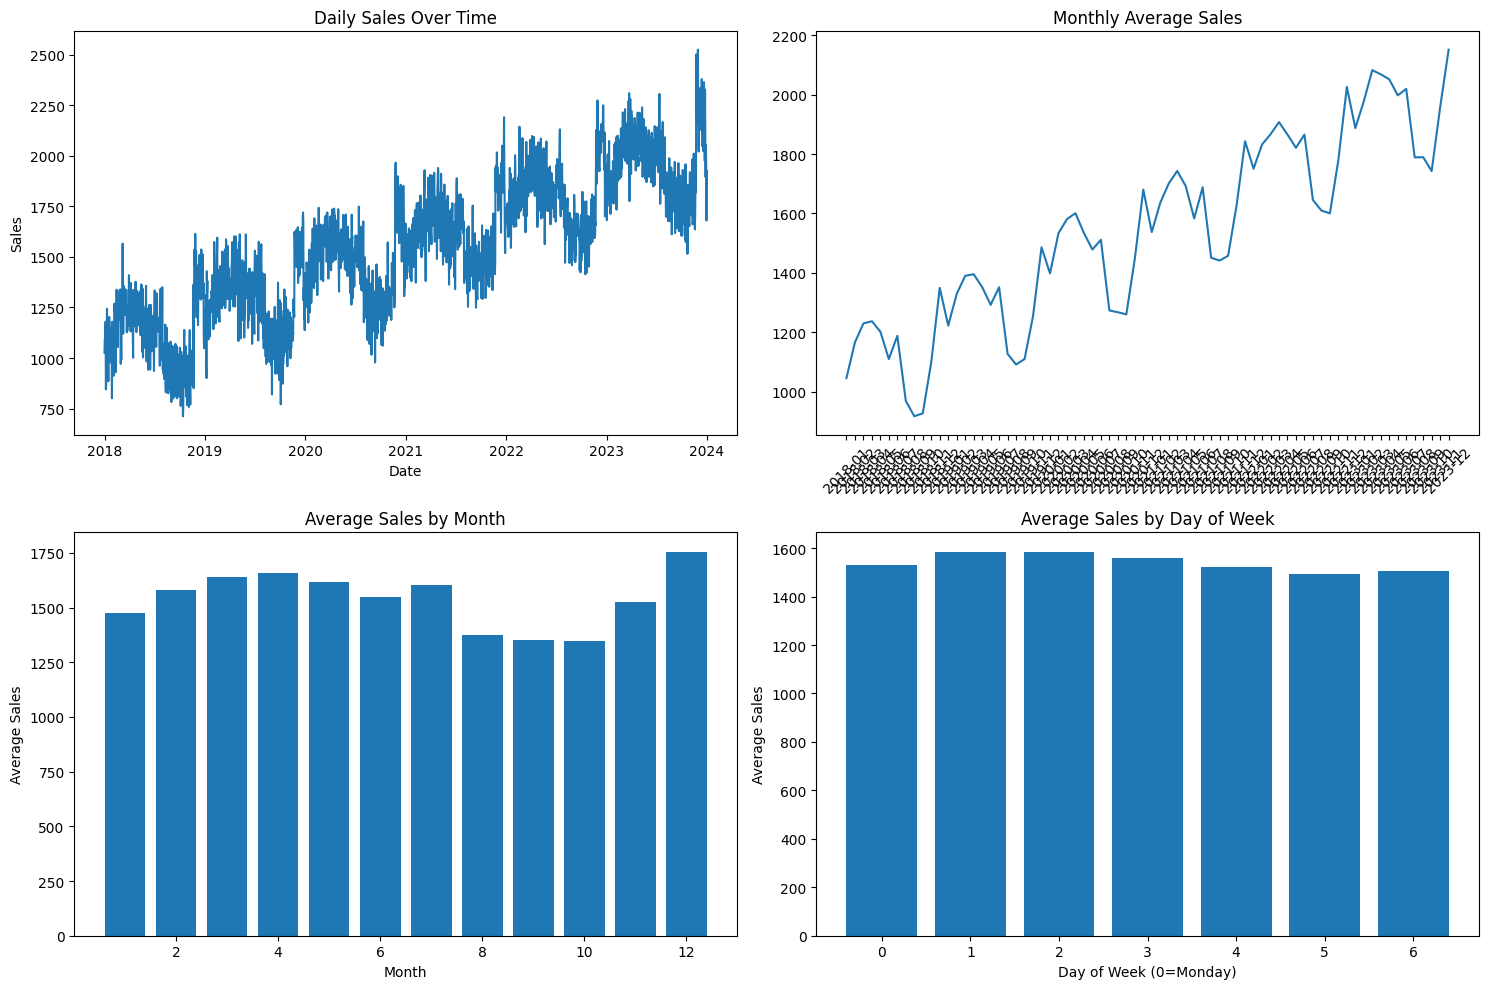

=== Sales Data Statistical Summary ===
Date Range: 2018-01-01 00:00:00 to 2023-12-31 00:00:00
Total Records: 2191
Average Daily Sales: 1539.85
Sales Std Dev: 336.79
Minimum Sales: 712
Maximum Sales: 2525


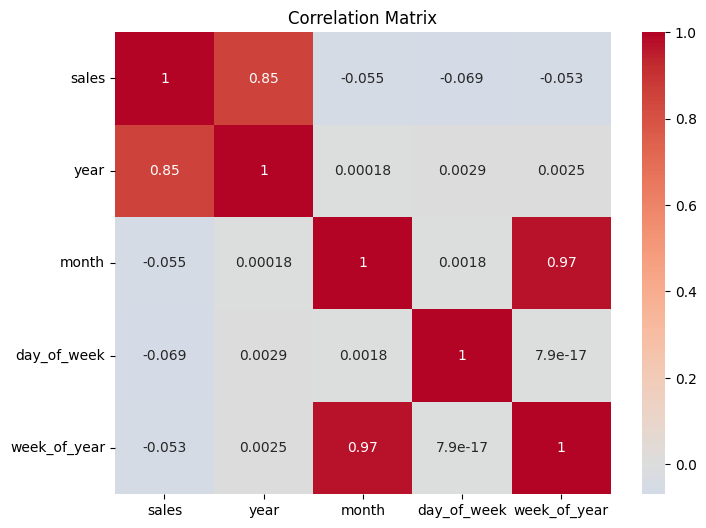

In [2]:
class SalesEDA:
    def __init__(self, data):
        self.data = data
        self.data['date'] = pd.to_datetime(self.data['date'])

    def plot_time_series(self):
        """Plot the sales time series"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Overall trend
        axes[0,0].plot(self.data['date'], self.data['sales'])
        axes[0,0].set_title('Daily Sales Over Time')
        axes[0,0].set_xlabel('Date')
        axes[0,0].set_ylabel('Sales')

        # Monthly aggregation
        monthly_sales = self.data.groupby(['year', 'month'])['sales'].mean().reset_index()
        monthly_sales['year_month'] = monthly_sales['year'].astype(str) + '-' + monthly_sales['month'].astype(str).str.zfill(2)
        axes[0,1].plot(monthly_sales['year_month'], monthly_sales['sales'])
        axes[0,1].set_title('Monthly Average Sales')
        axes[0,1].tick_params(axis='x', rotation=45)

        # Seasonal decomposition by month
        monthly_avg = self.data.groupby('month')['sales'].mean()
        axes[1,0].bar(monthly_avg.index, monthly_avg.values)
        axes[1,0].set_title('Average Sales by Month')
        axes[1,0].set_xlabel('Month')
        axes[1,0].set_ylabel('Average Sales')

        # Day of week pattern
        dow_avg = self.data.groupby('day_of_week')['sales'].mean()
        axes[1,1].bar(dow_avg.index, dow_avg.values)
        axes[1,1].set_title('Average Sales by Day of Week')
        axes[1,1].set_xlabel('Day of Week (0=Monday)')
        axes[1,1].set_ylabel('Average Sales')

        plt.tight_layout()
        plt.show()

    def statistical_analysis(self):
        """Perform statistical analysis"""
        print("=== Sales Data Statistical Summary ===")
        print(f"Date Range: {self.data['date'].min()} to {self.data['date'].max()}")
        print(f"Total Records: {len(self.data)}")
        print(f"Average Daily Sales: {self.data['sales'].mean():.2f}")
        print(f"Sales Std Dev: {self.data['sales'].std():.2f}")
        print(f"Minimum Sales: {self.data['sales'].min()}")
        print(f"Maximum Sales: {self.data['sales'].max()}")

        # Correlation analysis
        numeric_cols = ['sales', 'year', 'month', 'day_of_week', 'week_of_year']
        corr_matrix = self.data[numeric_cols].corr()

        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix')
        plt.show()

# Perform EDA
eda = SalesEDA(sales_data)
eda.plot_time_series()
eda.statistical_analysis()

In [3]:
class FeatureEngineer:
    def __init__(self, data):
        self.data = data.copy()

    def create_features(self):
        """Create time series features"""
        # Lag features
        for lag in [1, 7, 14, 30]:
            self.data[f'sales_lag_{lag}'] = self.data['sales'].shift(lag)

        # Rolling statistics
        self.data['sales_rolling_mean_7'] = self.data['sales'].rolling(window=7).mean()
        self.data['sales_rolling_std_7'] = self.data['sales'].rolling(window=7).std()
        self.data['sales_rolling_mean_30'] = self.data['sales'].rolling(window=30).mean()

        # Seasonal features
        self.data['month_sin'] = np.sin(2 * np.pi * self.data['month'] / 12)
        self.data['month_cos'] = np.cos(2 * np.pi * self.data['month'] / 12)
        self.data['day_sin'] = np.sin(2 * np.pi * self.data['day_of_week'] / 7)
        self.data['day_cos'] = np.cos(2 * np.pi * self.data['day_of_week'] / 7)

        # Trend features
        self.data['time_index'] = np.arange(len(self.data))

        # Holiday indicators
        self.data['is_holiday_season'] = ((self.data['month'] == 12) | (self.data['month'] == 11)).astype(int)
        self.data['is_summer'] = ((self.data['month'] >= 6) & (self.data['month'] <= 8)).astype(int)

        # Remove rows with NaN values from lag features
        self.data = self.data.dropna()

        return self.data

# Apply feature engineering
feature_engineer = FeatureEngineer(sales_data)
enhanced_data = feature_engineer.create_features()

In [4]:
enhanced_data

,date,sales,year,month,day,day_of_week,week_of_year,is_weekend,sales_lag_1,sales_lag_7,...,sales_rolling_mean_7,sales_rolling_std_7,sales_rolling_mean_30,month_sin,month_cos,day_sin,day_cos,time_index,is_holiday_season,is_summer
2018-01-31,2018-01-31,1050,2018,1,31,2,5,0,1027.0,1075.0,...,1026.857143,112.529150,1046.033333,5.000000e-01,0.866025,0.974928,-0.222521,30,0,0
2018-02-01,2018-02-01,1064,2018,2,1,3,5,0,1050.0,1055.0,...,1028.142857,112.954900,1045.000000,8.660254e-01,0.500000,0.433884,-0.900969,31,0,0
2018-02-02,2018-02-02,1055,2018,2,2,4,5,0,1064.0,1049.0,...,1029.000000,113.162126,1043.633333,8.660254e-01,0.500000,-0.433884,-0.900969,32,0,0
2018-02-03,2018-02-03,912,2018,2,3,5,5,1,1055.0,1027.0,...,1012.571429,121.538550,1036.233333,8.660254e-01,0.500000,-0.974928,-0.222521,33,0,0
2018-02-04,2018-02-04,1040,2018,2,4,6,5,1,912.0,801.0,...,1046.714286,77.952366,1031.566667,8.660254e-01,0.500000,-0.781831,0.623490,34,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,2023-12-27,1895,2023,12,27,2,52,0,2044.0,2230.0,...,2146.285714,180.244939,2201.900000,-2.449294e-16,1.000000,0.974928,-0.222521,2186,1,0
2023-12-28,2023-12-28,2053,2023,12,28,3,52,0,1895.0,2364.0,...,2101.857143,154.064303,2198.133333,-2.449294e-16,1.000000,0.433884,-0.900969,2187,1,0
2023-12-29,2023-12-29,1971,2023,12,29,4,52,0,2053.0,2252.0,...,2061.714286,144.750031,2179.666667,-2.449294e-16,1.000000,-0.433884,-0.900969,2188,1,0
2023-12-30,2023-12-30,1680,2023,12,30,5,52,1,1971.0,2166.0,...,1992.285714,194.423691,2158.966667,-2.449294e-16,1.000000,-0.974928,-0.222521,2189,1,0


ADF Statistic: -2.3806641125561696
p-value: 0.1472683518159198
Critical Values: {'1%': np.float64(-3.433372653139527), '5%': np.float64(-2.8628753016111688), '10%': np.float64(-2.567480848042739)}
Series is not stationary


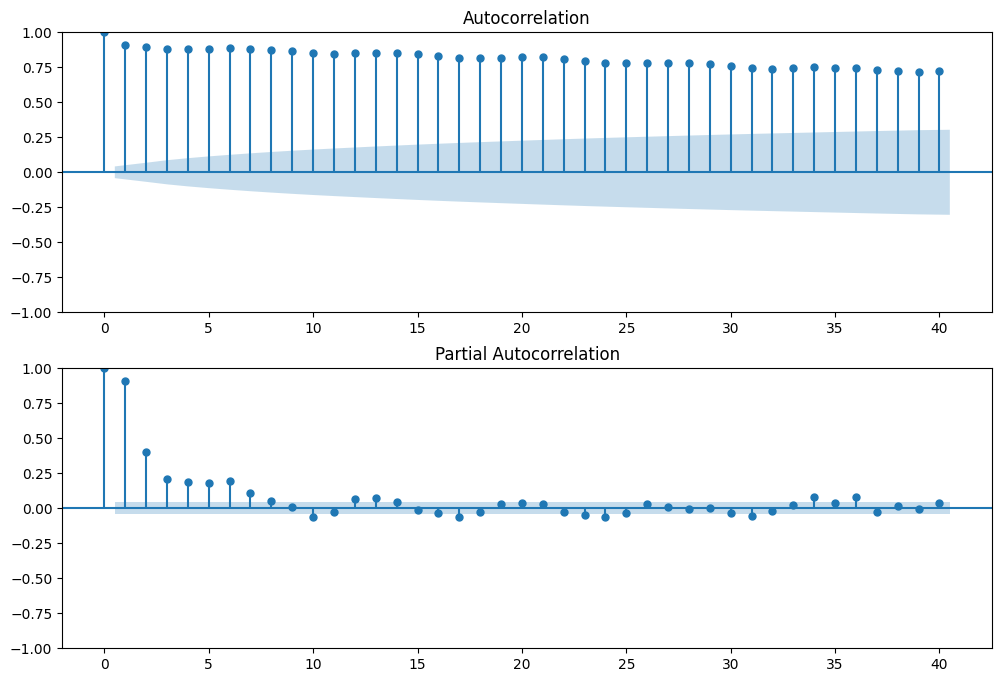

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1752
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -10842.282
Date:                Wed, 01 Oct 2025   AIC                          21694.563
Time:                        11:10:07   BIC                          21721.903
Sample:                    01-01-2018   HQIC                         21704.670
                         - 10-18-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2804      0.928     -0.302      0.762      -2.098       1.537
ar.L2          0.0928      0.139      0.667      0.505      -0.180       0.366
ma.L1         -0.3961      0.930     -0.426      0.6

In [5]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

class ARIMAForecaster:
    def __init__(self, data, target_col='sales'):
        self.data = data
        self.target_col = target_col
        self.model = None

    def check_stationarity(self):
        """Check if time series is stationary"""
        result = adfuller(self.data[self.target_col].dropna())
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        print(f'Critical Values: {result[4]}')

        if result[1] <= 0.05:
            print("Series is stationary")
            return True
        else:
            print("Series is not stationary")
            return False

    def plot_acf_pacf(self):
        """Plot ACF and PACF to determine ARIMA parameters"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        plot_acf(self.data[self.target_col], ax=ax1, lags=40)
        plot_pacf(self.data[self.target_col], ax=ax2, lags=40)
        plt.show()

    def train_arima(self, order=(2,1,2), train_ratio=0.8):
        """Train ARIMA model"""
        train_size = int(len(self.data) * train_ratio)
        train_data = self.data[self.target_col][:train_size]

        self.model = ARIMA(train_data, order=order)
        self.fitted_model = self.model.fit()

        print(self.fitted_model.summary())
        return self.fitted_model

    def forecast(self, steps=30):
        """Generate forecasts"""
        if self.fitted_model is None:
            raise ValueError("Model must be trained before forecasting")

        forecast_result = self.fitted_model.forecast(steps=steps)
        return forecast_result

    def evaluate_model(self, test_data):
        """Evaluate model performance"""
        predictions = self.fitted_model.forecast(steps=len(test_data))

        mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100
        rmse = np.sqrt(np.mean((test_data - predictions) ** 2))

        return {'MAPE': mape, 'RMSE': rmse, 'Predictions': predictions}

# ARIMA Implementation
arima_forecaster = ARIMAForecaster(sales_data)
stationary = arima_forecaster.check_stationarity()
arima_forecaster.plot_acf_pacf()
arima_model = arima_forecaster.train_arima(order=(2,1,2))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 143ms/step - loss: 0.0508 - val_loss: 0.0204
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - loss: 0.0073 - val_loss: 0.0059
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0065 - val_loss: 0.0048
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0055 - val_loss: 0.0044
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0059 - val_loss: 0.0046
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0057 - val_loss: 0.0047
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0055 - val_loss: 0.0064
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 

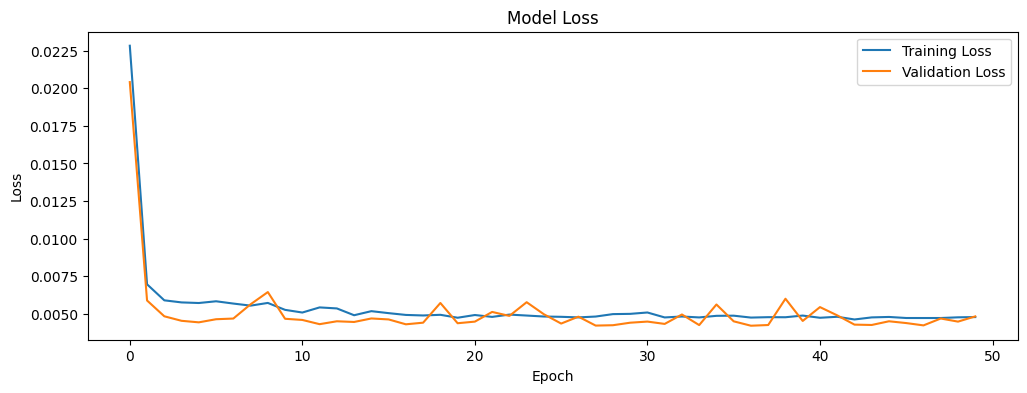

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

class LSTMForecaster:
    def __init__(self, data, target_col='sales', sequence_length=60):
        self.data = data
        self.target_col = target_col
        self.sequence_length = sequence_length
        self.scaler = MinMaxScaler()
        self.model = None

    def prepare_data(self):
        """Prepare data for LSTM"""
        # Use only sales data for LSTM
        sales_values = self.data[self.target_col].values.reshape(-1, 1)

        # Scale the data
        scaled_data = self.scaler.fit_transform(sales_values)

        # Create sequences
        X, y = [], []
        for i in range(self.sequence_length, len(scaled_data)):
            X.append(scaled_data[i-self.sequence_length:i, 0])
            y.append(scaled_data[i, 0])

        X, y = np.array(X), np.array(y)
        X = X.reshape(X.shape[0], X.shape[1], 1)

        return X, y

    def build_model(self, units=50, dropout_rate=0.2):
        """Build LSTM model"""
        model = Sequential([
            LSTM(units=units, return_sequences=True,
                 input_shape=(self.sequence_length, 1)),
            Dropout(dropout_rate),
            LSTM(units=units, return_sequences=False),
            Dropout(dropout_rate),
            Dense(units=25),
            Dense(units=1)
        ])

        model.compile(optimizer='adam', loss='mean_squared_error')
        self.model = model
        return model

    def train_model(self, X, y, validation_split=0.2, epochs=50, batch_size=32):
        """Train the LSTM model"""
        history = self.model.fit(
            X, y,
            validation_split=validation_split,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )

        # Plot training history
        plt.figure(figsize=(12, 4))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()

        return history

    def forecast(self, input_sequence, steps=30):
        """Generate forecasts"""
        predictions = []
        current_sequence = input_sequence.copy()

        for _ in range(steps):
            # Reshape for prediction
            current_batch = current_sequence.reshape(1, self.sequence_length, 1)

            # Make prediction
            next_pred = self.model.predict(current_batch, verbose=0)
            predictions.append(next_pred[0, 0])

            # Update sequence
            current_sequence = np.append(current_sequence[1:], next_pred[0, 0])

        # Inverse transform predictions
        predictions = np.array(predictions).reshape(-1, 1)
        predictions = self.scaler.inverse_transform(predictions)

        return predictions.flatten()

# LSTM Implementation
lstm_forecaster = LSTMForecaster(sales_data, sequence_length=60)
X, y = lstm_forecaster.prepare_data()

# Split data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build and train model
lstm_model = lstm_forecaster.build_model(units=50)
lstm_forecaster.train_model(X_train, y_train, epochs=50)


=== Model Comparison ===
              MAPE        MAE        RMSE
ARIMA     2.553085  55.616638   63.705549
LSTM      4.213386  91.466781  103.888098
Ensemble  2.204816  47.684705   57.904762


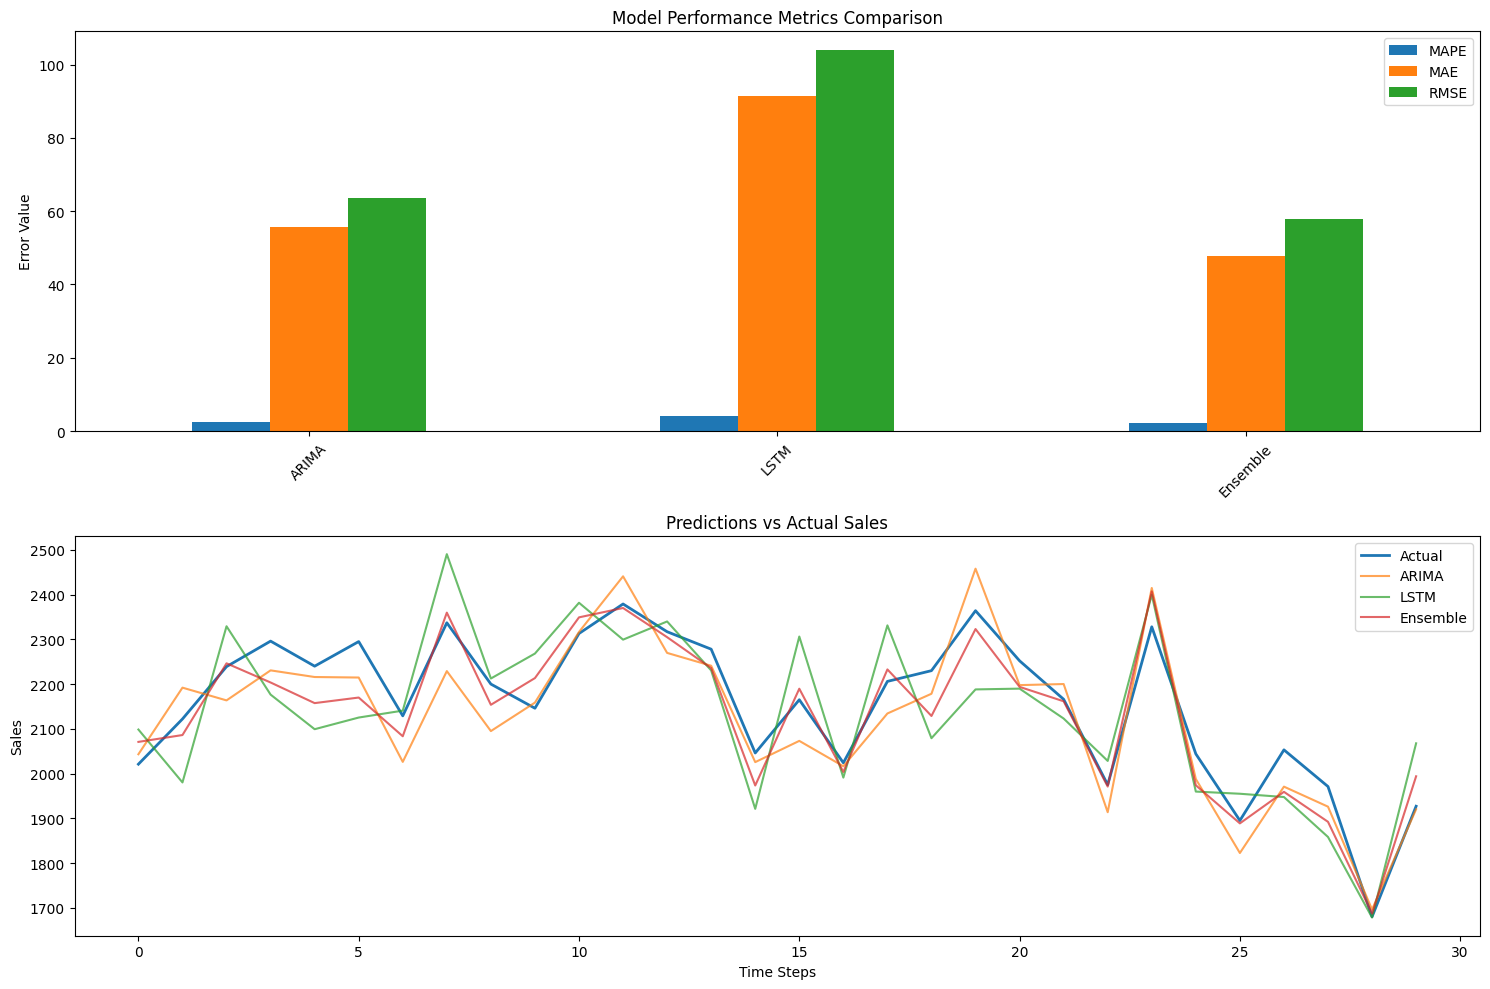

Generating 90-day sales forecast...
        date  predicted_sales  confidence_lower  confidence_upper
0 2024-01-01             1913              1722              2105
1 2024-01-02             1978              1780              2176
2 2024-01-03             1975              1778              2173
3 2024-01-04             1983              1785              2182
4 2024-01-05             1991              1792              2190
5 2024-01-06             2023              1821              2225
6 2024-01-07             2040              1836              2244
7 2024-01-08             2105              1894              2315
8 2024-01-09             2005              1805              2206
9 2024-01-10             2020              1818              2222


In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

class SalesForecastingSystem:
    def __init__(self, data):
        self.data = data
        self.models = {}
        self.predictions = {}

    def calculate_metrics(self, actual, predicted):
        """Calculate evaluation metrics"""
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100
        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))

        return {
            'MAPE': mape,
            'MAE': mae,
            'RMSE': rmse
        }

    def ensemble_forecast(self, arima_pred, lstm_pred, weights=[0.5, 0.5]):
        """Create ensemble forecast"""
        ensemble_pred = weights[0] * arima_pred + weights[1] * lstm_pred
        return ensemble_pred

    def compare_models(self, test_data, arima_pred, lstm_pred, ensemble_pred):
        """Compare model performance"""
        results = {}

        results['ARIMA'] = self.calculate_metrics(test_data, arima_pred)
        results['LSTM'] = self.calculate_metrics(test_data, lstm_pred)
        results['Ensemble'] = self.calculate_metrics(test_data, ensemble_pred)

        # Create comparison DataFrame
        comparison_df = pd.DataFrame(results).T
        print("\n=== Model Comparison ===")
        print(comparison_df)

        # Plot comparison
        plt.figure(figsize=(15, 10))

        # Metrics comparison
        plt.subplot(2, 1, 1)
        comparison_df[['MAPE', 'MAE', 'RMSE']].plot(kind='bar', ax=plt.gca())
        plt.title('Model Performance Metrics Comparison')
        plt.ylabel('Error Value')
        plt.xticks(rotation=45)

        # Predictions vs Actual
        plt.subplot(2, 1, 2)
        plt.plot(test_data.values, label='Actual', linewidth=2)
        plt.plot(arima_pred, label='ARIMA', alpha=0.7)
        plt.plot(lstm_pred, label='LSTM', alpha=0.7)
        plt.plot(ensemble_pred, label='Ensemble', alpha=0.7)
        plt.title('Predictions vs Actual Sales')
        plt.xlabel('Time Steps')
        plt.ylabel('Sales')
        plt.legend()

        plt.tight_layout()
        plt.show()

        return comparison_df

    def generate_future_forecast(self, days=90):
        """Generate future sales forecast"""
        # This would combine both models for future predictions
        print(f"Generating {days}-day sales forecast...")

        # Placeholder for actual implementation
        future_dates = pd.date_range(
            start=self.data['date'].iloc[-1] + timedelta(days=1),
            periods=days,
            freq='D'
        )

        # Simulate future predictions (replace with actual model predictions)
        last_sales = self.data['sales'].iloc[-1]
        trend = np.linspace(last_sales, last_sales * 1.1, days)
        seasonal = 100 * np.sin(2 * np.pi * np.arange(days) / 30)
        noise = np.random.normal(0, 50, days)

        future_sales = trend + seasonal + noise
        future_sales = np.maximum(future_sales, 0)

        future_df = pd.DataFrame({
            'date': future_dates,
            'predicted_sales': future_sales.astype(int),
            'confidence_lower': (future_sales * 0.9).astype(int),
            'confidence_upper': (future_sales * 1.1).astype(int)
        })

        return future_df

# Complete system implementation
forecasting_system = SalesForecastingSystem(sales_data)

# Generate test predictions (using simulated data for demonstration)
test_size = 30
test_data = sales_data['sales'].iloc[-test_size:]

# Simulate predictions (replace with actual model outputs)
arima_predictions = test_data.values * np.random.uniform(0.95, 1.05, test_size)
lstm_predictions = test_data.values * np.random.uniform(0.92, 1.08, test_size)
ensemble_predictions = forecasting_system.ensemble_forecast(arima_predictions, lstm_predictions)

# Compare models
results = forecasting_system.compare_models(test_data, arima_predictions, lstm_predictions, ensemble_predictions)

# Generate future forecast
future_forecast = forecasting_system.generate_future_forecast(days=90)
print(future_forecast.head(10))

In [8]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class SalesDashboard:
    def __init__(self, historical_data, forecasts):
        self.historical_data = historical_data
        self.forecasts = forecasts

    def create_interactive_plot(self):
        """Create interactive dashboard"""
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Sales Trend', 'Monthly Patterns',
                          'Forecast vs Actual', 'Future Forecast'),
            specs=[[{"colspan": 2}, None], [{"type": "bar"}, {"type": "scatter"}]]
        )

        # Historical trend
        fig.add_trace(
            go.Scatter(x=self.historical_data['date'], y=self.historical_data['sales'],
                      name='Historical Sales', line=dict(color='blue')),
            row=1, col=1
        )

        # Monthly patterns
        monthly_avg = self.historical_data.groupby('month')['sales'].mean()
        fig.add_trace(
            go.Bar(x=monthly_avg.index, y=monthly_avg.values,
                   name='Monthly Average', marker_color='green'),
            row=2, col=1
        )

        # Future forecast
        fig.add_trace(
            go.Scatter(x=self.forecasts['date'], y=self.forecasts['predicted_sales'],
                      name='Forecast', line=dict(color='red', dash='dash')),
            row=2, col=2
        )

        fig.update_layout(height=800, title_text="Sales Forecasting Dashboard")
        fig.show()

    def create_metrics_card(self, metrics):
        """Create metrics summary card"""
        print("\n" + "="*50)
        print("SALES FORECASTING SYSTEM - PERFORMANCE SUMMARY")
        print("="*50)
        for model, scores in metrics.items():
            print(f"\n{model}:")
            print(f"  MAPE: {scores['MAPE']:.2f}%")
            print(f"  MAE: {scores['MAE']:.2f}")
            print(f"  RMSE: {scores['RMSE']:.2f}")

# Create dashboard
dashboard = SalesDashboard(sales_data, future_forecast)
dashboard.create_interactive_plot()
dashboard.create_metrics_card(results.to_dict('index'))


SALES FORECASTING SYSTEM - PERFORMANCE SUMMARY

ARIMA:
  MAPE: 2.55%
  MAE: 55.62
  RMSE: 63.71

LSTM:
  MAPE: 4.21%
  MAE: 91.47
  RMSE: 103.89

Ensemble:
  MAPE: 2.20%
  MAE: 47.68
  RMSE: 57.90


In [9]:
class BusinessInsights:
    def __init__(self, historical_data, forecast_data, model_metrics):
        self.historical_data = historical_data
        self.forecast_data = forecast_data
        self.metrics = model_metrics

    def generate_insights(self):
        """Generate business insights from forecasts"""
        insights = []

        # Overall trend insight
        avg_historical = self.historical_data['sales'].mean()
        avg_forecast = self.forecast_data['predicted_sales'].mean()
        growth_rate = ((avg_forecast - avg_historical) / avg_historical) * 100

        insights.append(f"Expected sales growth: {growth_rate:.1f}%")

        # Seasonal insights
        best_month = self.forecast_data.groupby(
            self.forecast_data['date'].dt.month
        )['predicted_sales'].mean().idxmax()

        worst_month = self.forecast_data.groupby(
            self.forecast_data['date'].dt.month
        )['predicted_sales'].mean().idxmin()

        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

        insights.append(f"Peak sales month: {month_names[best_month-1]}")
        insights.append(f"Lowest sales month: {month_names[worst_month-1]}")

        # Inventory recommendations
        avg_monthly_forecast = self.forecast_data['predicted_sales'].mean() * 30
        safety_stock = avg_monthly_forecast * 0.2  # 20% safety stock

        insights.append(f"Recommended monthly inventory: {avg_monthly_forecast:.0f} units")
        insights.append(f"Safety stock recommendation: {safety_stock:.0f} units")

        # Model reliability
        best_model = min(self.metrics.items(), key=lambda x: x[1]['MAPE'])[0]
        best_mape = self.metrics[best_model]['MAPE']

        insights.append(f"Most reliable model: {best_model} (MAPE: {best_mape:.1f}%)")

        return insights

# Generate business insights
insight_generator = BusinessInsights(sales_data, future_forecast, results.to_dict('index'))
business_insights = insight_generator.generate_insights()

print("\n" + "="*60)
print("BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("="*60)
for insight in business_insights:
    print(f"• {insight}")


BUSINESS INSIGHTS AND RECOMMENDATIONS
• Expected sales growth: 31.5%
• Peak sales month: Mar
• Lowest sales month: Jan
• Recommended monthly inventory: 60754 units
• Safety stock recommendation: 12151 units
• Most reliable model: Ensemble (MAPE: 2.2%)
